In [1]:
import torch
import torch.nn as nn                   #for sequence api in torch
from torch.utils.data import DataLoader #for loading images
import numpy as np                      #just in case if you need numpy arrays
import torchvision.transforms as T      #Used for data preprocessing and converting images to tensors
import torchvision.datasets as dset
import torch.optim as optim             #For using the desired parameter update
import torch.nn.functional as F

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

dtype = torch.float32

print("Using device: ",device)

Using device:  cuda


Target label: sad


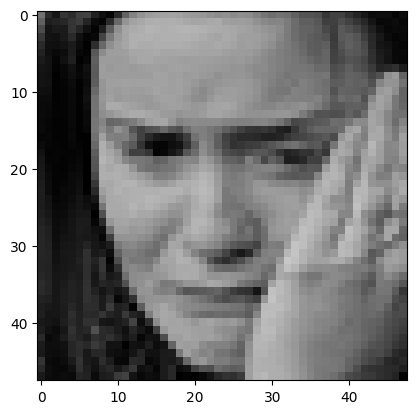

In [3]:
import torchvision.transforms as T
import torchvision.datasets as dset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random                   # For selecting a random element from the list

# Define transformations
transform = T.Compose([T.RandomHorizontalFlip(), T.ToTensor()])

# Training data
train_data = dset.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/images/train", transform=transform)
loaded_train = DataLoader(train_data, batch_size=64, shuffle=True)

# Validation data
validation_data = dset.ImageFolder("D:/projects/machine learning/Expression-recognition/jonathanheix dataset/images/images/validation", transform=transform)
loaded_validation = DataLoader(validation_data, batch_size=64, shuffle=False)

# Lists for tracking loss and accuracy
loss_history = []
validation_acc = []
training_acc = []

# Visualization setup
%matplotlib inline              

# Load a batch of training data
dataiter = iter(loaded_train)  # Using loaded_train instead of loader_train
images, labels = next(dataiter)  # Use next() to get the batch
expression = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}  # Mapping for labels

# Display a random image and its label
random_idx = random.sample(range(0, 64), 1)[0]  # Select a random index from 0 to 63
print("Target label:", expression[int(labels[random_idx].numpy())])  # Convert label tensor to numpy and map to expression
plt.imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))  # Display image
plt.show()

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import os
from PIL import Image
from pickle import dump, load
from sklearn.svm import SVC
from torchvision import transforms
